# Structure Data for BPNN

In [5]:
%load_ext autoreload
%autoreload 2

from Dataset import *
import numpy as np
from bpnn import BPNN
from tqdm.notebook import tqdm

def convert_categories(y_cat):
    desired = np.array([0 if y[0] == 1 else 1 for y in y_cat])
    return desired

def get_data():
    d = Dataset.load_gzip(os.path.join(
        "datasets", "face_mask_pickled"), "dataset_gray_conv_test_2.pkl.gzip")

    ndimen = d.train.X.shape[1]

    # Structure Training Data for BPNN
    training_inputs = [np.reshape(np.asarray(x), (ndimen, 1)) for x in d.train.X]
    training_results = [np.asarray(y.reshape(-1, 1)) for y in d.train.y]

    training_data = zip(training_inputs, training_results)
    # Structure Validation Data for BPNN
    validation_inputs = [np.reshape(np.asarray(x), (ndimen, 1)) for x in d.validation.X]
    validation_data = zip(validation_inputs, convert_categories(d.validation.y))
    # Structure Testing Data for BPNN
    testing_inputs = [np.reshape(np.asarray(x), (ndimen, 1)) for x in d.test.X]
    testing_data = zip(testing_inputs, convert_categories(d.test.y))

    return training_data, validation_data, testing_data, ndimen


# Train Best BPNN Configuration

In [6]:

"""
# Best Hyperparameters:
- Best Network Configuration: [900, 100, 2]
- Best Batch Size: 20
- Best Learning Rate: 0.45
"""

training_data, validation_data, testing_data, ndimen = get_data()
print(f"Input Dimension: {ndimen}")


max_epochs = 15
init_nc = [900, 100, 2]
init_b = 20
init_lr = 0.45

model_BPNN = BPNN(init_nc, verbose=True)
final_score, eval_scores, eval_scores_deltas, conv_time = model_BPNN.train(training_data,
                                                                           max_epochs=max_epochs,
                                                                           batch_size=init_b,
                                                                           learning_rate=init_lr,
                                                                           evaluation_data=validation_data)


Input Dimension: 900
# Training MLP Network: Sizes=[900, 100, 2]	Epochs=15	Batch-Size=20	Learning-Rate=0.45
 - Training Data Len: 10000
 - Validation Data Len: 800
# Epochs:
	1. Correct 634/800	(score: 0.7925	delta: 0.7925	delta_avg: 0.7925)
	2. Correct 703/800	(score: 0.8788	delta: 0.0863	delta_avg: 0.4394)
	3. Correct 710/800	(score: 0.8875	delta: 0.0087	delta_avg: 0.2958)
	4. Correct 711/800	(score: 0.8888	delta: 0.0013	delta_avg: 0.2222)
	5. Correct 714/800	(score: 0.8925	delta: 0.0037	delta_avg: 0.1785)
	6. Correct 722/800	(score: 0.9025	delta: 0.01	delta_avg: 0.1504)
	7. Correct 722/800	(score: 0.9025	delta: 0.0	delta_avg: 0.1289)
	8. Correct 722/800	(score: 0.9025	delta: 0.0	delta_avg: 0.1128)
	9. Correct 726/800	(score: 0.9075	delta: 0.005	delta_avg: 0.1008)
	10. Correct 727/800	(score: 0.9087	delta: 0.0012	delta_avg: 0.0909)
	11. Correct 730/800	(score: 0.9125	delta: 0.0038	delta_avg: 0.083)
	12. Correct 731/800	(score: 0.9137	delta: 0.0012	delta_avg: 0.0761)
	13. Correct 732/

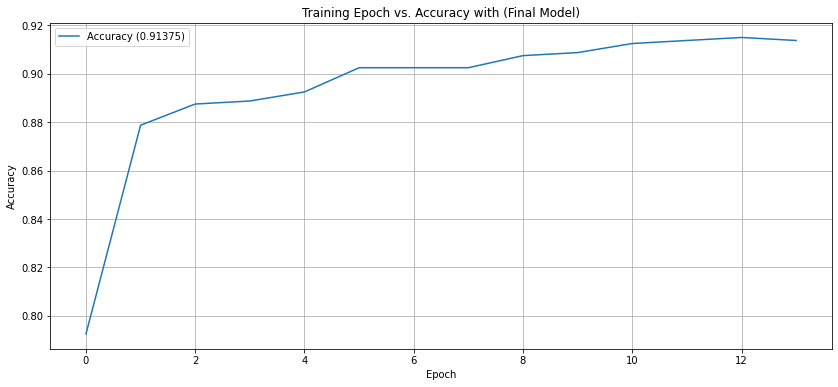

In [9]:
fig = plt.figure(figsize=(14, 6))

plt.title(f"Training Epoch vs. Accuracy with (Final Model)")
plt.xlabel("Epoch")
plt.ylabel('Accuracy')

plt.plot(eval_scores, label=f'Accuracy ({final_score})')

plt.grid()
plt.legend()
plt.show()
fig.savefig(f'img/bpnn_best_model', dpi=100)

# Save Best Model & Predictions

In [12]:
import gzip

# make directory to save generated images to
os.makedirs('models', exist_ok=True)

def save_best_model():
    # Save the best BPNN model to a pickle file
    with gzip.open('models/bpnn_best_model_numpy.pkl.gzip', 'wb') as f:
        pickle.dump(model_BPNN, f)
    
def save_testing_pred(data):
    # Tuples (X, y, y_pred)
    
    new_data = []
    for (x, y) in data:
        decision = np.argmax(model_BPNN.feedforward(x))
        new_data.append((x, y, decision))
        
    with gzip.open('models/bpnn_testing_pred_numpy.pkl.gzip', 'wb') as f:
        pickle.dump(new_data, f)


training_data, validation_data, testing_data, ndimen = get_data()
save_best_model()
save_testing_pred(testing_data)


# Load the Model

In [6]:

import pickle
import gzip
# Load the best model from file
with gzip.open('models/bpnn_best_model_numpy.pkl.gzip', 'rb') as f:
    nn = pickle.load(f)

# Evaluate Model

In [7]:
def evaluate(dataset, name):

    acc = 0
    acc0 = 0
    len0 = 0
    acc1 = 0
    len1 = 0

    for (x, y) in dataset:
        decision = np.argmax(nn.feedforward(x))

        if decision == y:
            acc += 1
        if y == 0:
            len0 += 1
            if decision == y:
                acc0 += 1
        if y == 1:
            len1 += 1
            if decision == y:
                acc1 += 1

    nn_acc = acc / (len0 + len1)
    # Compute class accuracies
    nn_acc0 = acc0 / len0
    nn_acc1 = acc1 / len1

    print(f'Overall {name} Accuracy: {nn_acc}')
    print(f'Class 0 {name} Accuracy: {nn_acc0}')
    print(f'Class 1 {name} Accuracy: {nn_acc1}')
    
    return nn_acc, nn_acc0, nn_acc1


training_data, validation_data, testing_data, ndimen = get_data()


vnn_acc, vnn_acc0, vnn_acc1 = evaluate(validation_data, "Validation")
print()
tnn_acc, tnn_acc0, tnn_acc1 = evaluate(testing_data, "Testing")



Overall Validation Accuracy: 0.91375
Class 0 Validation Accuracy: 0.9
Class 1 Validation Accuracy: 0.9275

Overall Testing Accuracy: 0.9122983870967742
Class 0 Testing Accuracy: 0.9135559921414538
Class 1 Testing Accuracy: 0.9109730848861284


# Plot Bar Chart

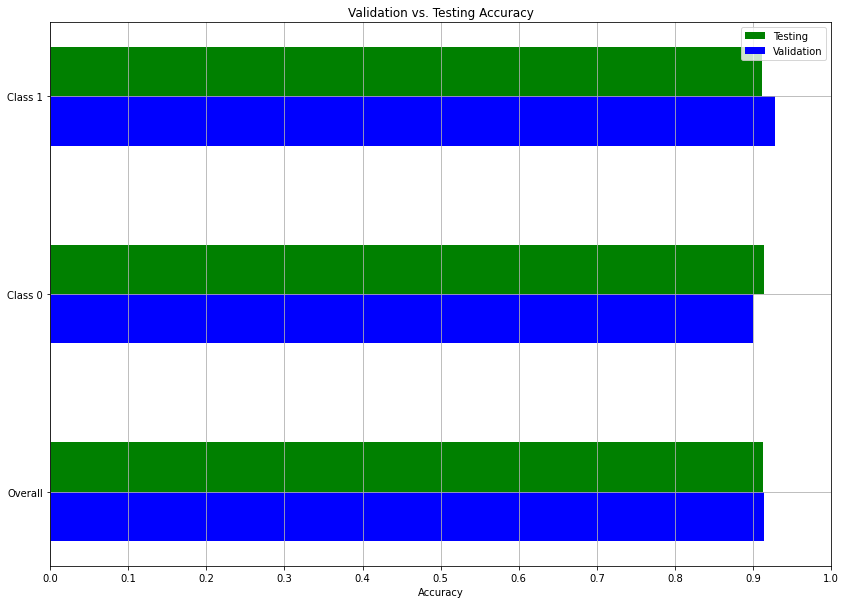

In [8]:
# Plot a barchart comparing the validation vs testing accuracies overall, for class 0, and for class 1 side by side

# set the y axis major ticks to .1 and minor ticks to .01
major_ticks = np.arange(0, 1.1, 0.1)
minor_ticks = np.arange(0, 1.1, 0.01)



fig = plt.figure(figsize=(14, 10))

plt.title(f"Validation vs. Testing Accuracy")
plt.xlabel("Accuracy")

width = 0.25
plt.barh(0 + width/2, tnn_acc, width, label='Testing', color='green')
plt.barh(0 - width/2, vnn_acc, width, label='Validation', color='blue')

plt.barh(1 + width/2, tnn_acc0, width, color='green')
plt.barh(1 - width/2, vnn_acc0, width, color='blue')

plt.barh(2 + width/2, tnn_acc1, width, color='green')
plt.barh(2 - width/2, vnn_acc1, width, color='blue')

plt.yticks(np.arange(0, 3, 1), ['Overall', 'Class 0', 'Class 1'])
plt.xticks(major_ticks)
plt.grid()
plt.legend()
plt.show()
fig.savefig(f'img/bpnn_validation_vs_testing', dpi=100)
